In [1]:
"""
Celii adapted code for pinky 100 run 2 for direct connectivity

"""

'\nCelii adapted code for pinky 100 run 2 for direct connectivity\n\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [3]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


# Direct Connection

## Orientation / direction tuning 

In [6]:
# Exclude synapses, segments and restrict by functional confidence 

synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation

In [12]:
soma #& "cell_class='excitatory'"

segmentation segmentation id,segment_id segment id unique within each Segmentation,soma_id soma id in Allen annotation database,soma_x x location of soma in grid coordinates,soma_y y location of soma in grid coordinates,soma_z z location of soma in grid coordinates,cell_class cell class
3,648518346341371119,329,105998,71204,669,excitatory
3,648518346341373204,417,59596,69165,2132,glia
3,648518346341380687,433,53383,62029,354,glia
3,648518346341382424,415,58087,60834,159,glia
3,648518346341388647,424,80108,56958,2080,glia
3,648518346341394877,458,94337,41289,2133,glia
3,648518346342018870,445,79431,67616,403,glia
3,648518346342162152,455,69091,74601,1902,glia
3,648518346342792054,423,116198,61856,2148,glia
3,648518346342792054,454,114059,59673,1975,glia


In [8]:
# number of direct connections (synapses) for each functional soma pair (both presyn and postsyn are somas with functional traces)

#gets all of the synapses where the presyn and postsyn are both soma cells
fun_fun_syn = synapse & soma.proj(presyn = 'segment_id') & soma.proj(postsyn = 'segment_id') 
#adds up the number of synapses for each soma-soma combination (some wont have a combination because not have synapse between them)
n_syn = dj.U('presyn', 'postsyn').aggr(fun_fun_syn, n_syn = 'count(*)') # soma-soma pairs with at least one synapse
n_syn

presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,n_syn calculated attribute
648518346341371119,648518346349471565,1
648518346341373204,648518346349484832,1
648518346341373204,648518346349503011,1
648518346341373204,648518346349503086,1
648518346341373204,648518346349506159,1
648518346341373204,648518346349506513,1
648518346341373204,648518346349510792,1
648518346341380687,648518346349496058,1
648518346341380687,648518346349498482,1
648518346341380687,648518346349506425,1


In [13]:
soma.proj(presyn = 'segment_id') # just renames the presyn

segmentation segmentation id,presyn segment id unique within each Segmentation,soma_id soma id in Allen annotation database
3,648518346341371119,329
3,648518346341373204,417
3,648518346341380687,433
3,648518346341382424,415
3,648518346341388647,424
3,648518346341394877,458
3,648518346342018870,445
3,648518346342162152,455
3,648518346342792054,423
3,648518346342792054,454


In [14]:
ta3p100 = dj.create_virtual_module("ta3p100","microns_ta3p100")


In [16]:
"""
Shows that soma_id was not a primary key in the ta3p100, so have to filter it away
in order to get total presyn-postsyn combinations

"""
soma_ta3p100 = (ta3p100.AllenSoma - ta3p100.SegmentExclude) & ta3p100.CurrentSegmentation
soma_ta3p100

segmentation segmentation id,segment_id segment id unique within each Segmentation,soma_id soma id in Allen annotation database,soma_x x location of soma in grid coordinates,soma_y y location of soma in grid coordinates,soma_z z location of soma in grid coordinates
2,648518346341366885,249,80400,59847,2141
2,648518346341371119,329,105998,71204,669
2,648518346341382424,415,58087,60834,159
2,648518346341388820,349,62856,70644,500
2,648518346341393609,337,93149,68319,371
2,648518346341394877,458,94337,41289,2133
2,648518346342018870,445,79431,67616,403
2,648518346342162152,455,69091,74601,1902
2,648518346342766796,431,50598,67772,997
2,648518346342797556,343,115024,57441,2098


In [17]:
soma_no_id = dj.U("segmentation","segment_id") & soma
soma_no_id

segmentation segmentation id,segment_id segment id unique within each Segmentation
3,648518346341371119
3,648518346341373204
3,648518346341380687
3,648518346341382424
3,648518346341388647
3,648518346341394877
3,648518346342018870
3,648518346342162152
3,648518346342792054
3,648518346342795947


In [18]:
#gets all the possible combinations of soma to soma where they aren't the same segment
all_fun_fun = soma_no_id.proj(presyn = 'segment_id') * soma_no_id.proj(postsyn = 'segment_id') & 'presyn != postsyn'
all_fun_fun

segmentation segmentation id,presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation
3,648518346341371119,648518346341382424
3,648518346341371119,648518346346301067
3,648518346341371119,648518346349471562
3,648518346341371119,648518346349473835
3,648518346341371119,648518346349475540
3,648518346341371119,648518346349478785
3,648518346341371119,648518346349482020
3,648518346341371119,648518346349487432
3,648518346341371119,648518346349489861
3,648518346341371119,648518346349491816


In [19]:
#the difference between these two numbers will tell how many soma-soma pairs don't have any synapses
print(len(n_syn),len(all_fun_fun),(len(all_fun_fun)-len(n_syn)))

4251 158802 154551


In [21]:
#makes a generic table for all soma combinations that assymes no synapses between them
rel = (dj.U('presyn', 'postsyn') & all_fun_fun).proj('presyn', 'postsyn', n_syn='0')
rel

presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,n_syn calculated attribute
648518346341371119,648518346341382424,0
648518346341371119,648518346346301067,0
648518346341371119,648518346349471562,0
648518346341371119,648518346349473835,0
648518346341371119,648518346349475540,0
648518346341371119,648518346349478785,0
648518346341371119,648518346349482020,0
648518346341371119,648518346349487432,0
648518346341371119,648518346349489861,0
648518346341371119,648518346349491816,0


In [24]:
dj.U("presyn","postsyn",'n_add') & n_syn.proj(n_add='n_syn')

presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,n_add calculated attribute
648518346341371119,648518346349471565,1
648518346341373204,648518346349484832,1
648518346341373204,648518346349503011,1
648518346341373204,648518346349503086,1
648518346341373204,648518346349506159,1
648518346341373204,648518346349506513,1
648518346341373204,648518346349510792,1
648518346341380687,648518346349496058,1
648518346341380687,648518346349498482,1
648518346341380687,648518346349506425,1


In [25]:
#combines the base generic 0 synapse table with the one with actual values
#rel is the base table and they are adding the synapse table to it
total_n_syn = rel.aggr(dj.U('n_add') * n_syn.proj(n_add='n_syn'), n_syn_total='n_syn + ifnull(n_add, 0)', keep_all_rows=True)# fill out all zeros
total_n_syn
#reciprocal_pairs = (n_syn * n_syn.proj(postsyn='presyn', presyn='postsyn', n_syn_2='n_syn')).proj(n_syn = 'n_syn + n_syn_2')



presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,n_syn_total calculated attribute
648518346341371119,648518346341373204,0
648518346341371119,648518346341380687,0
648518346341371119,648518346341382424,0
648518346341371119,648518346341388647,0
648518346341371119,648518346341394877,0
648518346341371119,648518346342018870,0
648518346341371119,648518346342162152,0
648518346341371119,648518346342792054,0
648518346341371119,648518346342795947,0
648518346341371119,648518346342801515,0


In [29]:
#make sure added correctly
len(total_n_syn & "n_syn_total>0"),len(n_syn & "n_syn>0")

(4249, 4251)

In [30]:
#there doesn't seem to be a pair in the rel that is in the n_syn (this is probably because there is a seg A - seg A synapse
n_syn.proj() - rel.proj()

presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation
648518346349509523,648518346349509523
648518346349510792,648518346349510792


## Should count undirected soma-soma pairs, i.e. A->B and B->A synpases summed together for connection between A and B


In [32]:
len(total_n_syn)/2

79401.0

In [31]:
"""
if made n x n combination box with presyns on x and postsyns on y 
a (where presyn < postsyn) is the top right traingle
b (presyn > postsyn) is bottom right triangle

We want every combination of A --> B added together
A (presyn) to B (postsyn) + B (presyn) to A (postsyn)
"""

combine a-b and b-a connections into one number, and segment_id1 < segment_id2
attrs = ['presyn', 'postsyn', 'n_syn_total']
a = (total_n_syn & 'presyn < postsyn').proj('presyn', 'postsyn', n_syn1 = 'n_syn_total')
b = (total_n_syn & 'presyn > postsyn').proj(n_syn2 = 'n_syn_total', postsyn = 'presyn', presyn = 'postsyn')




postsyn segment id unique within each Segmentation,presyn segment id unique within each Segmentation,n_syn2 calculated attribute
648518346341373204,648518346341371119,0
648518346341380687,648518346341371119,0
648518346341380687,648518346341373204,0
648518346341382424,648518346341371119,0
648518346341382424,648518346341373204,0
648518346341382424,648518346341380687,0
648518346341388647,648518346341371119,1
648518346341388647,648518346341373204,0
648518346341388647,648518346341380687,0
648518346341388647,648518346341382424,1


In [33]:
"""adds up the non-directional number of synapses for A --> B and B --> A
## *** can use projections to rename primary keys ***
Uses table a as the base table so that is where presyn is less than the postsyn

"""

undirected_n_syn = (a * b).proj(n_syn_total = 'n_syn1 + n_syn2', segment_id1 = 'presyn', segment_id2 = 'postsyn')
undirected_n_syn

segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,n_syn_total calculated attribute
648518346341371119,648518346341373204,0
648518346341371119,648518346341380687,0
648518346341371119,648518346341382424,0
648518346341371119,648518346341388647,1
648518346341371119,648518346341394877,1
648518346341371119,648518346342018870,0
648518346341371119,648518346342162152,0
648518346341371119,648518346342792054,0
648518346341371119,648518346342795947,0
648518346341371119,648518346342801515,0


In [37]:
tuned = 'confidence > 0.5'
sig_units = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & tuned
sig_units

segmentation segmentation id,vonbestfit_method method index,segment_id segment id unique within each Segmentation,von_hash unique hash for combination of sta analysis methods,base von mises baseline amplitude,thetas von mises gaussian peak angle (descending amp order),amps von mises gaussian amplitudes (descending amp order),sharps von mises gaussian sharpness (descending amp order),flat_pred predictive performance of flat mean,von_pred predictive performance of von fit on unshuffled data,shuff_pred predictive performance of von fit on shuffled data,von_pred_adv von mises predictive advantage over shuffled data,von_p_value fit component p_value by reshuffle,confidence confidence value that neuron is good match
3,1,648518346341352891,2488ca428583222f70981b01e4b84c81,0.0142162,=BLOB=,=BLOB=,=BLOB=,0.0625723,0.0540431,0.0618035,0.124022,0.001,0.9393616940050551
3,1,648518346341356241,66dc6420ca132a85ddda25939f084caa,0.00565237,=BLOB=,=BLOB=,=BLOB=,0.0202752,0.0178552,0.0200274,0.107137,0.001,0.957373658926309
3,1,648518346341356256,73dbecb8885beae030be3c263406f897,0.025249,=BLOB=,=BLOB=,=BLOB=,0.0679271,0.063242,0.0669904,0.0551834,0.001,1.7858262119801065
3,1,648518346341359123,8e54b140337daf69dfda4e9fbe14ae7f,0.0297197,=BLOB=,=BLOB=,=BLOB=,0.141441,0.122979,0.139556,0.117201,0.001,3.708831526488791
3,1,648518346341361981,f0c077c6b3ec8074c419a09fbb23388b,0.00287949,=BLOB=,=BLOB=,=BLOB=,0.0234285,0.0217913,0.0229093,0.0477177,0.001,1.4644267171718275
3,1,648518346341362771,a7d6d9bb9c79de84f8792c46b1516c16,0.047481,=BLOB=,=BLOB=,=BLOB=,0.681801,0.587579,0.668815,0.119148,0.001,0.6869009007690088
3,1,648518346341368192,0a0ee3399963886c58e9eaad755d146e,0.0163345,=BLOB=,=BLOB=,=BLOB=,0.160254,0.149098,0.157911,0.0549933,0.001,0.835527390590717
3,1,648518346341369370,8e4dd43ab0a7846e5013ecc6025e9acc,0.0193596,=BLOB=,=BLOB=,=BLOB=,0.234322,0.210452,0.230954,0.087497,0.001,0.5961253447331519
3,1,648518346341379312,8f3db7b9d61c1c8458fe115a339c7b86,0.000641483,=BLOB=,=BLOB=,=BLOB=,0.0427635,0.0370261,0.0422116,0.12126,0.001,0.5843029464358273
3,1,648518346341380003,19e96ac874b4a28742a27fe748a2eee5,0.0130354,=BLOB=,=BLOB=,=BLOB=,0.0147111,0.0132691,0.0145349,0.0860418,0.001,1.083702586790154


In [38]:
#gets all the combination of significant units and then restricts to the upper right triangle by saying
# 1st segment have to less than 2nd segment (which is same case for the undirected_n_syn)
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                 sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'
sig_unit_pairs

segmentation segmentation id,vonbestfit_method method index,segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation
3,1,648518346341352891,648518346341356241
3,1,648518346341352891,648518346341356256
3,1,648518346341352891,648518346341359123
3,1,648518346341352891,648518346341361981
3,1,648518346341352891,648518346341362771
3,1,648518346341352891,648518346341368192
3,1,648518346341352891,648518346341369370
3,1,648518346341352891,648518346341379312
3,1,648518346341352891,648518346341380003
3,1,648518346341352891,648518346341380208


In [50]:
radtune.BestVonCorr()

von_hash1 unique hash for combination of sta analysis methods,von_hash2 unique hash for combination of sta analysis methods,segmentation segmentation id,segment_id1 segment id unique within each Segmentation,segment_id2 segment id unique within each Segmentation,diff_pref_ori difference in preferred orientation (radians),diff_pref_dir difference in preferred direction (radians),diff_sharp difference in tuning sharpness,diff_osi difference in orientation sensitivity index,diff_dsi difference in direction sensitivity index,von_corr pearson corr btw von mises fitted points per tested dir,von_corr_pvalue pearson corr pvalue btw von mises fitted points per tested dir,diff_v_adv difference in unshuffled von mises prediction advantage,diff_v_pvalue difference in unshuffled von mises p value
001d4ff043b1dbc3d93c71cd4c1b58b7,0297bd0896cc7b7664696963366c9fe5,3,648518346349301817,648518346349478399,1.19933,-1.94226,-8.35197,-0.17332,0.291705,-0.158794,0.556934,-0.0505817,0.009
001d4ff043b1dbc3d93c71cd4c1b58b7,029fb310d2cdd697fcfe00c9bea3b7bb,3,648518346349301817,648518346349478700,0.123898,0.123898,-10.1181,-0.0656761,-0.372382,0.821547,9.5046e-05,-0.0465576,0.014
001d4ff043b1dbc3d93c71cd4c1b58b7,031f711ebcfc32eefdaa86e9912d1efa,3,648518346349301817,648518346349499636,0.337544,-2.80405,-17.3555,-0.00560445,-0.242274,0.230441,0.390542,0.0027417,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,03bdec379cc98e379ff8e602d7c729fc,3,648518346349301817,648518346349506808,0.4659,-2.67569,-5.74436,0.0269199,0.0636525,-0.0603409,0.824325,0.0036514,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,03e2192ccc0cd113728cd1bc93afd5a6,3,648518346349301817,648518346349511381,0.823465,0.823465,-4.56802,-0.0669775,0.291705,-0.131564,0.627189,-0.0436206,0.005
001d4ff043b1dbc3d93c71cd4c1b58b7,0427999279dd6571f0dc76dde8da95a4,3,648518346349301817,648518346349511528,1.14388,1.14388,10.6238,0.00630268,0.0133766,-0.151817,0.574609,-0.0186979,0.0
001d4ff043b1dbc3d93c71cd4c1b58b7,0465606d04077b6f072a5df948ec840f,3,648518346349301817,648518346349470217,-1.24467,1.89692,17.1072,-0.0664242,-0.427709,-0.169776,0.529606,-0.0432703,0.006
001d4ff043b1dbc3d93c71cd4c1b58b7,054e4314f9504e2dd5276890649d927c,3,648518346349301817,648518346349511212,0.420748,-2.72084,0.996527,0.00598417,0.243338,-0.059982,0.825355,-0.0298631,0.001
001d4ff043b1dbc3d93c71cd4c1b58b7,07186306fa90e3f81af03721f8e40aee,3,648518346349301817,648518346349387852,-1.0969,2.0447,4.0225,-0.0953084,0.291705,-0.144395,0.59366,-0.0627499,0.057
001d4ff043b1dbc3d93c71cd4c1b58b7,08123f88bb1d3b8ef4794431abaab654,3,648518346349301817,648518346349509390,0.752962,-2.38863,32.8259,-0.0514866,0.291705,-0.109539,0.686337,-0.0513561,0.019


In [49]:
radtune.BestVonCorr.describe()
print("hi")

# quantify correlation and difference (hash2-hash1) in hashes characterized in BestVonFit
-> radtune.VonCorr
-> pinky.Segment.proj(segment_id1="segment_id")
-> pinky.Segment.proj(segment_id2="segment_id")
---
diff_pref_ori=null   : float                        # difference in preferred orientation (radians)
diff_pref_dir=null   : float                        # difference in preferred direction (radians)
diff_sharp=null      : float                        # difference in tuning sharpness
diff_osi=null        : float                        # difference in orientation sensitivity index
diff_dsi=null        : float                        # difference in direction sensitivity index
von_corr=null        : float                        # pearson corr btw von mises fitted points per tested dir
von_corr_pvalue=null : float                        # pearson corr pvalue btw von mises fitted points per tested dir
diff_v_adv=null      : float                        # difference in unshuffled von mise

In [39]:
"""
gets all fo the directional difference data (stored in radtune.BestVonCorr ) 
for only the significant units combinations and adds on the n_synapses
they share between themselves, then puts it in a pandas data frame
"""
radconn_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * undirected_n_syn).fetch())

In [40]:
radconn_df

,von_hash1,von_hash2,segmentation,segment_id1,segment_id2,diff_pref_ori,diff_pref_dir,diff_sharp,diff_osi,diff_dsi,von_corr,von_corr_pvalue,diff_v_adv,diff_v_pvalue,n_syn_total
0,104cb5878f833fe425a0ee7750d69024,ea7d60f34fe148d38a772c45ffd9d8d2,3,648518346349470171,648518346349471565,-0.704885,2.436710,-9.794720,0.014314,-0.001648,-0.228183,3.953290e-01,0.192564,0.0,0
1,104cb5878f833fe425a0ee7750d69024,121f62f7bfd521edb32dcd89bc0e696b,3,648518346349470171,648518346349472574,1.099010,-2.042580,33.939700,-0.038188,0.896415,-0.137342,6.120010e-01,-0.163081,0.0,0
2,104cb5878f833fe425a0ee7750d69024,f1448fe54d7da24075bef555d7184f43,3,648518346349470171,648518346349473792,1.008290,1.008290,-12.444800,-0.058904,0.578025,-0.280846,2.920420e-01,-0.159227,0.0,0
3,104cb5878f833fe425a0ee7750d69024,8bb981b069c568955229b118039acae2,3,648518346349470171,648518346349473833,0.083231,0.083231,-8.391860,0.014314,0.024366,0.911939,8.702150e-07,0.271693,0.0,0
4,104cb5878f833fe425a0ee7750d69024,4e1a88968fc9c4fd63b99635861b8291,3,648518346349470171,648518346349475536,-0.707149,-0.707149,-8.798980,-0.015137,0.059412,-0.232292,3.866390e-01,-0.112428,0.0,0
5,104cb5878f833fe425a0ee7750d69024,acc70407cc0825b60a383220645cfad3,3,648518346349470171,648518346349475573,-0.777880,2.363710,-18.795200,0.014314,0.499034,-0.176254,5.137760e-01,-0.167026,0.0,0
6,104cb5878f833fe425a0ee7750d69024,179cf4d8a3038c2320b9e000437c78f3,3,648518346349470171,648518346349482312,-0.491841,-0.491841,-18.531000,0.014314,0.071560,0.242059,3.664020e-01,-0.157049,0.0,0
7,104cb5878f833fe425a0ee7750d69024,9916df1ccda2f731198b80dc2a43fb43,3,648518346349470171,648518346349483124,1.412860,1.412860,-7.814100,0.000992,0.311270,-0.297007,2.639500e-01,0.097691,0.0,0
8,104cb5878f833fe425a0ee7750d69024,f7978bf93ae7d47941bef9ca9d26145f,3,648518346349470171,648518346349488659,0.714534,0.714534,33.939700,-0.079048,0.891009,-0.134251,6.201070e-01,-0.178869,0.0,0
9,104cb5878f833fe425a0ee7750d69024,449763d90b8a0bb06dde845df8f35af3,3,648518346349470171,648518346349491811,1.073450,-2.068140,-19.265100,-0.004708,0.413413,-0.358793,1.723430e-01,-0.007869,0.0,0


In [ ]:
# functional metrics for each functional soma pair (restricting by radtune fitting significance)

""" ***** just broke this out into smaller pieces

tuned = 'confidence > 0.5'
sig_units = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & tuned
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                 sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

radconn_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * undirected_n_syn).fetch())

**************************************  """ 

'''
# dataframe for directed connections, i.e. a-b different from b-a

attrs = ['von_hash1', 'von_hash2', 'segmentation', 'segment_id1', 'segment_id2', 'diff_pref_ori', 'diff_pref_dir', 'diff_sharp', 'diff_osi', 'diff_dsi', 'von_corr', 'von_corr_pvalue', 'diff_v_adv', 'diff_v_pvalue']

radconn_pairs1 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn
radconn_pairs2 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn

radconn_df1 = pd.DataFrame(radconn_pairs1.fetch())
radconn_df2 = pd.DataFrame(radconn_pairs2.fetch())
radconn_df = pd.concat([radconn_df1, radconn_df2], ignore_index=True)
'''


In [41]:
#finding the sum of the total number of direct connections
sum(radconn_df['n_syn_total'].values)

32

In [ ]:
"""
Reminder:
Orientation (0 - 180) is the counter clockwise angle between the horizontal line and the line segment
--> maximum difference between two orientational preferences = 90
Direction (0 - 360): where it is actually pointing from the center fo a circle
--> maximum difference between two directional preferences = 180



"""

In [ ]:
#Example of how this makes sense:
ori_diff_ex = -0.704
dir_diff_ex = 2.436

print(ori_diff_ex*rad2deg,dir_diff_ex*rad2deg)

"""
Conclusion: this makes perfect sense becasue
'
   '
      '
______________________
          '
             '
               '
               
if line A = solid (pointing right), B = Dotted (pointing up left)
Difference in direction = Dir_B - Dir_A = 130 - 0 = 130
Orientation is measured as the degree rotating counter clockwise from the horizontal line
Ori_B = 0, Ori_A = -40 - 0 = -40 
"""

In [44]:
dir_edges

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265])

-40.33622877720995 139.57251889386853


In [46]:
# set up bins for difference in preferred direction (which can only be 180 max apart)
rad2deg = 180/np.pi #gets the conversion rate
dir_edges = np.linspace(0, np.pi, 5) #marks the edges for 4 bins from 0 to pi
de = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in dir_edges]]) #convert the radian boundaries to degrees
print(de)
dir_labels = list(zip(de[:-1], de[1:])) #gets the pairing of the min and max of each bin
print(dir_labels)
dir_centers = np.round((dir_edges[1:] + dir_edges[:-1])/2 * rad2deg, decimals=2) #gets the centers of all the bins in degrees
print(dir_centers)

['0', '45', '90', '135', '180']
[('0', '45'), ('45', '90'), ('90', '135'), ('135', '180')]
[ 22.5  67.5 112.5 157.5]


In [52]:
# set up bins for difference in prefered orientation 
ori_edges = np.linspace(0, np.pi /2 ,5) #maximum difference it can be is 90 degrees
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
print(oe)
ori_labels = list(zip(oe[:-1], oe[1:]))
print(ori_labels)
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 
print(ori_centers)

['0', '22', '45', '68', '90']
[('0', '22'), ('22', '45'), ('45', '68'), ('68', '90')]
[11.25 33.75 56.25 78.75]


In [57]:
# set up bins for difference in tuning sharpness

#have to measure what the min and max are for the tuning sharpness and then creates 5 bins
sharp_edges = np.linspace(min(np.abs(radconn_df['diff_sharp'])), max(np.abs(radconn_df['diff_sharp'])), 6)
print(sharp_edges)
se = list(['{:.1f}'.format(ee) for ee in sharp_edges])
print(se)
sharp_labels = list(zip(se[:-1], se[1:]))
print(sharp_labels)
sharp_centers = np.hstack((np.nan, np.round((sharp_edges[1:] + sharp_edges[:-1])/2, decimals=2), np.nan))
print(sharp_centers)


[ 0.      11.08186 22.16372 33.24558 44.32744 55.4093 ]
['0.0', '11.1', '22.2', '33.2', '44.3', '55.4']
[('0.0', '11.1'), ('11.1', '22.2'), ('22.2', '33.2'), ('33.2', '44.3'), ('44.3', '55.4')]
[  nan  5.54 16.62 27.7  38.79 49.87   nan]


In [54]:
help(np.digitize)

Help on function digitize in module numpy:

digitize(x, bins, right=False)
    Return the indices of the bins to which each value in input array belongs.
    
    =========  =============  ============================
    `right`    order of bins  returned index `i` satisfies
    =========  =============  ============================
    ``False``  increasing     ``bins[i-1] <= x < bins[i]``
    ``True``   increasing     ``bins[i-1] < x <= bins[i]``
    ``False``  decreasing     ``bins[i-1] > x >= bins[i]``
    ``True``   decreasing     ``bins[i-1] >= x > bins[i]``
    =========  =============  ============================
    
    If values in `x` are beyond the bounds of `bins`, 0 or ``len(bins)`` is
    returned as appropriate.
    
    Parameters
    ----------
    x : array_like
        Input array to be binned. Prior to NumPy 1.10.0, this array had to
        be 1-dimensional, but can now have any shape.
    bins : array_like
        Array of bins. It has to be 1-dimensional and 

In [59]:
sharp_edges

array([ 0.     , 11.08186, 22.16372, 33.24558, 44.32744, 55.4093 ])

In [55]:
# bin diff_pref_ori, diff_pref_dir, diff_sharp

"""
stores the bin center for the bin that the difference delongs in
np.digitize returns the bin index + 1 of the bin that the value would belong in
"""
radconn_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radconn_df['diff_pref_ori']), ori_edges)) - 1]
radconn_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radconn_df['diff_pref_dir']), dir_edges)) - 1]
radconn_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radconn_df['diff_sharp']), sharp_edges))] 
#^^ because have nans on the edges then don't need to subtract by one

In [56]:
radconn_df

,von_hash1,von_hash2,segmentation,segment_id1,segment_id2,diff_pref_ori,diff_pref_dir,diff_sharp,diff_osi,diff_dsi,von_corr,von_corr_pvalue,diff_v_adv,diff_v_pvalue,n_syn_total,bin_diff_pref_ori,bin_diff_pref_dir,bin_diff_sharp
0,104cb5878f833fe425a0ee7750d69024,ea7d60f34fe148d38a772c45ffd9d8d2,3,648518346349470171,648518346349471565,-0.704885,2.436710,-9.794720,0.014314,-0.001648,-0.228183,3.953290e-01,0.192564,0.0,0,33.75,157.5,5.54
1,104cb5878f833fe425a0ee7750d69024,121f62f7bfd521edb32dcd89bc0e696b,3,648518346349470171,648518346349472574,1.099010,-2.042580,33.939700,-0.038188,0.896415,-0.137342,6.120010e-01,-0.163081,0.0,0,56.25,112.5,38.79
2,104cb5878f833fe425a0ee7750d69024,f1448fe54d7da24075bef555d7184f43,3,648518346349470171,648518346349473792,1.008290,1.008290,-12.444800,-0.058904,0.578025,-0.280846,2.920420e-01,-0.159227,0.0,0,56.25,67.5,16.62
3,104cb5878f833fe425a0ee7750d69024,8bb981b069c568955229b118039acae2,3,648518346349470171,648518346349473833,0.083231,0.083231,-8.391860,0.014314,0.024366,0.911939,8.702150e-07,0.271693,0.0,0,11.25,22.5,5.54
4,104cb5878f833fe425a0ee7750d69024,4e1a88968fc9c4fd63b99635861b8291,3,648518346349470171,648518346349475536,-0.707149,-0.707149,-8.798980,-0.015137,0.059412,-0.232292,3.866390e-01,-0.112428,0.0,0,33.75,22.5,5.54
5,104cb5878f833fe425a0ee7750d69024,acc70407cc0825b60a383220645cfad3,3,648518346349470171,648518346349475573,-0.777880,2.363710,-18.795200,0.014314,0.499034,-0.176254,5.137760e-01,-0.167026,0.0,0,33.75,157.5,16.62
6,104cb5878f833fe425a0ee7750d69024,179cf4d8a3038c2320b9e000437c78f3,3,648518346349470171,648518346349482312,-0.491841,-0.491841,-18.531000,0.014314,0.071560,0.242059,3.664020e-01,-0.157049,0.0,0,33.75,22.5,16.62
7,104cb5878f833fe425a0ee7750d69024,9916df1ccda2f731198b80dc2a43fb43,3,648518346349470171,648518346349483124,1.412860,1.412860,-7.814100,0.000992,0.311270,-0.297007,2.639500e-01,0.097691,0.0,0,78.75,67.5,5.54
8,104cb5878f833fe425a0ee7750d69024,f7978bf93ae7d47941bef9ca9d26145f,3,648518346349470171,648518346349488659,0.714534,0.714534,33.939700,-0.079048,0.891009,-0.134251,6.201070e-01,-0.178869,0.0,0,33.75,22.5,38.79
9,104cb5878f833fe425a0ee7750d69024,449763d90b8a0bb06dde845df8f35af3,3,648518346349470171,648518346349491811,1.073450,-2.068140,-19.265100,-0.004708,0.413413,-0.358793,1.723430e-01,-0.007869,0.0,0,56.25,112.5,16.62


In [60]:
# convert n_syn_total into binary values
"""
Adds on binary value if they synapsed onto each other
"""
radconn_df['n_syn_binary'] = 1 * (radconn_df['n_syn_total'] > 0).values
radconn_df


,von_hash1,von_hash2,segmentation,segment_id1,segment_id2,diff_pref_ori,diff_pref_dir,diff_sharp,diff_osi,diff_dsi,von_corr,von_corr_pvalue,diff_v_adv,diff_v_pvalue,n_syn_total,bin_diff_pref_ori,bin_diff_pref_dir,bin_diff_sharp,n_syn_binary
0,104cb5878f833fe425a0ee7750d69024,ea7d60f34fe148d38a772c45ffd9d8d2,3,648518346349470171,648518346349471565,-0.704885,2.436710,-9.794720,0.014314,-0.001648,-0.228183,3.953290e-01,0.192564,0.0,0,33.75,157.5,5.54,0
1,104cb5878f833fe425a0ee7750d69024,121f62f7bfd521edb32dcd89bc0e696b,3,648518346349470171,648518346349472574,1.099010,-2.042580,33.939700,-0.038188,0.896415,-0.137342,6.120010e-01,-0.163081,0.0,0,56.25,112.5,38.79,0
2,104cb5878f833fe425a0ee7750d69024,f1448fe54d7da24075bef555d7184f43,3,648518346349470171,648518346349473792,1.008290,1.008290,-12.444800,-0.058904,0.578025,-0.280846,2.920420e-01,-0.159227,0.0,0,56.25,67.5,16.62,0
3,104cb5878f833fe425a0ee7750d69024,8bb981b069c568955229b118039acae2,3,648518346349470171,648518346349473833,0.083231,0.083231,-8.391860,0.014314,0.024366,0.911939,8.702150e-07,0.271693,0.0,0,11.25,22.5,5.54,0
4,104cb5878f833fe425a0ee7750d69024,4e1a88968fc9c4fd63b99635861b8291,3,648518346349470171,648518346349475536,-0.707149,-0.707149,-8.798980,-0.015137,0.059412,-0.232292,3.866390e-01,-0.112428,0.0,0,33.75,22.5,5.54,0
5,104cb5878f833fe425a0ee7750d69024,acc70407cc0825b60a383220645cfad3,3,648518346349470171,648518346349475573,-0.777880,2.363710,-18.795200,0.014314,0.499034,-0.176254,5.137760e-01,-0.167026,0.0,0,33.75,157.5,16.62,0
6,104cb5878f833fe425a0ee7750d69024,179cf4d8a3038c2320b9e000437c78f3,3,648518346349470171,648518346349482312,-0.491841,-0.491841,-18.531000,0.014314,0.071560,0.242059,3.664020e-01,-0.157049,0.0,0,33.75,22.5,16.62,0
7,104cb5878f833fe425a0ee7750d69024,9916df1ccda2f731198b80dc2a43fb43,3,648518346349470171,648518346349483124,1.412860,1.412860,-7.814100,0.000992,0.311270,-0.297007,2.639500e-01,0.097691,0.0,0,78.75,67.5,5.54,0
8,104cb5878f833fe425a0ee7750d69024,f7978bf93ae7d47941bef9ca9d26145f,3,648518346349470171,648518346349488659,0.714534,0.714534,33.939700,-0.079048,0.891009,-0.134251,6.201070e-01,-0.178869,0.0,0,33.75,22.5,38.79,0
9,104cb5878f833fe425a0ee7750d69024,449763d90b8a0bb06dde845df8f35af3,3,648518346349470171,648518346349491811,1.073450,-2.068140,-19.265100,-0.004708,0.413413,-0.358793,1.723430e-01,-0.007869,0.0,0,56.25,112.5,16.62,0


In [62]:
#only saves the pairs that synapsed onto each other and the bins for their differences 
radconn_df_part = radconn_df[radconn_df['n_syn_total'] > 0]
radconn_df_part

,von_hash1,von_hash2,segmentation,segment_id1,segment_id2,diff_pref_ori,diff_pref_dir,diff_sharp,diff_osi,diff_dsi,von_corr,von_corr_pvalue,diff_v_adv,diff_v_pvalue,n_syn_total,bin_diff_pref_ori,bin_diff_pref_dir,bin_diff_sharp,n_syn_binary
11,104cb5878f833fe425a0ee7750d69024,c58b95168e713f24be6938c707e03493,3,648518346349470171,648518346349493653,-0.355753,2.785840,-1.546380,-0.024599,0.706160,0.218743,4.156880e-01,-0.153617,0.0,1,11.25,157.5,5.54,1
19,104cb5878f833fe425a0ee7750d69024,88c64b811901223715b2ee813f1db8b4,3,648518346349470171,648518346349499896,-0.813855,2.327740,-12.575800,-0.038543,0.611733,-0.232812,3.855460e-01,-0.161534,0.0,2,56.25,112.5,16.62,1
21,104cb5878f833fe425a0ee7750d69024,337c1a683d195e49560e1abc5c6a54e0,3,648518346349470171,648518346349500277,0.632507,0.632507,1.760200,0.014314,0.630332,-0.135995,6.155300e-01,-0.174272,0.0,1,33.75,22.5,5.54,1
24,104cb5878f833fe425a0ee7750d69024,392d08dcbec7557dbd3ffa99de523bb7,3,648518346349470171,648518346349504065,0.533053,0.533053,-13.759100,0.006288,0.058375,0.025956,9.239830e-01,0.121729,0.0,2,33.75,22.5,16.62,1
40,104cb5878f833fe425a0ee7750d69024,09a421c1a34db87041109648eb98eb4f,3,648518346349470171,648518346349513026,0.967888,0.967888,-10.426200,-0.024341,0.035484,-0.317851,2.302570e-01,-0.060541,0.0,1,56.25,67.5,5.54,1
45,ea7d60f34fe148d38a772c45ffd9d8d2,4e1a88968fc9c4fd63b99635861b8291,3,648518346349471565,648518346349475536,-0.002264,3.139330,0.995744,-0.029451,0.061060,0.985667,3.208850e-12,-0.304992,0.0,3,11.25,157.5,5.54,1
48,ea7d60f34fe148d38a772c45ffd9d8d2,9916df1ccda2f731198b80dc2a43fb43,3,648518346349471565,648518346349483124,-1.023850,-1.023850,1.980620,-0.013322,0.312919,-0.347972,1.865970e-01,-0.094873,0.0,2,56.25,67.5,5.54,1
58,ea7d60f34fe148d38a772c45ffd9d8d2,031f711ebcfc32eefdaa86e9912d1efa,3,648518346349471565,648518346349499636,-0.182326,-0.182326,-6.447030,-0.052716,0.364085,0.826245,7.990910e-05,-0.343683,0.0,1,11.25,22.5,5.54,1
79,ea7d60f34fe148d38a772c45ffd9d8d2,e919798a1aefa68a9f3512c13ebbaf39,3,648518346349471565,648518346349512869,0.668040,-2.473550,6.836820,-0.025364,-0.091596,-0.186747,4.886090e-01,-0.297003,0.0,1,33.75,157.5,5.54,1
88,121f62f7bfd521edb32dcd89bc0e696b,9916df1ccda2f731198b80dc2a43fb43,3,648518346349472574,648518346349483124,0.313847,-2.827750,-41.753800,0.039180,-0.585145,0.092485,7.333570e-01,0.260772,0.0,1,11.25,157.5,38.79,1


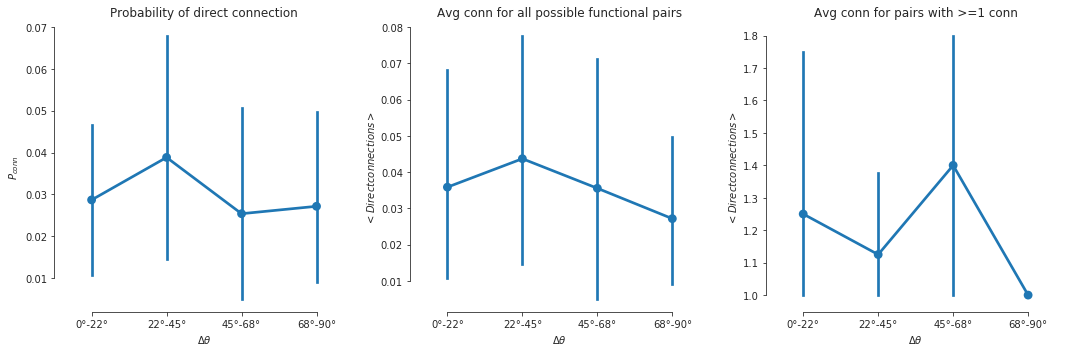

In [63]:
# for difference in preferred orientation 

"""
Use point plots to measure the cental tendency of a scatter plot and the error bars around it
- scatter plot in the case is the x value of 1 of 4 bins and then the presence of a direction connection or not
 ---> y axis is the mean of the number of direct connections 
"""

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_ori', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_pref_ori', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_pref_ori', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()



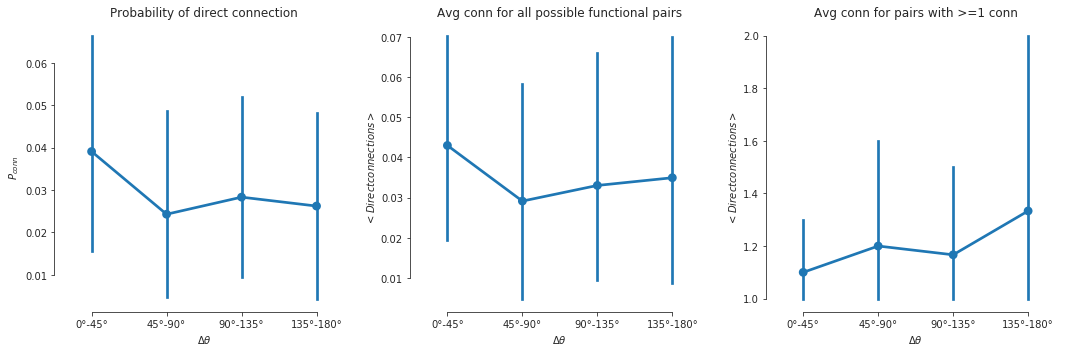

In [64]:
# for difference in preferred direction 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_dir', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_pref_dir', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_pref_dir', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()


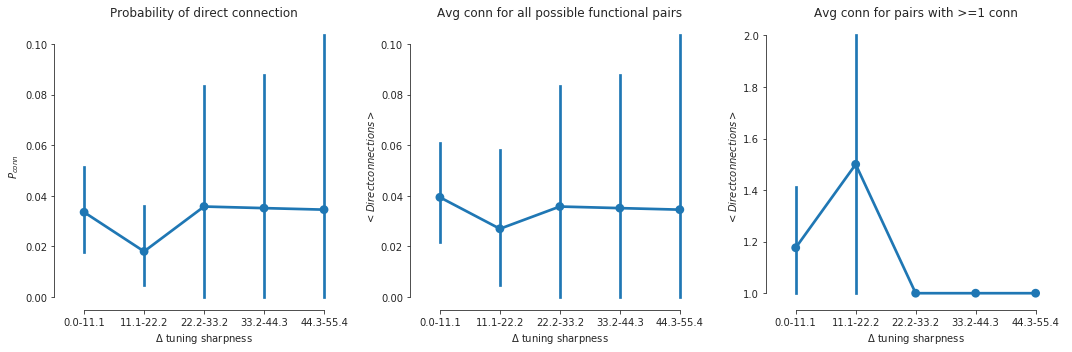

In [65]:
# for difference in tuning sharpness

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_sharp', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_sharp', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_sharp', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[0].set_xlabel(r'$\Delta$ tuning sharpness')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[1].set_xlabel(r'$\Delta$ tuning sharpness')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[2].set_xlabel(r'$\Delta$ tuning sharpness')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()


## Receptive field

In [67]:
# functional metrics for each functional soma pair (restricting by spattune fitting significance)

"""
For each of the significant units combinations (according to the sta_snr number defined in BestSTA)
-> gets the receptive field data on them and aggends the number of direction connections
"""

sig_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                  sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

spatconn_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * undirected_n_syn).fetch())

'''
# dataframe for directed connections, i.e. a-b different from b-a

attrs = ['sta_hash1', 'sta_hash2', 'apert_radius', 'segmentation', 'segment_id1', 'segment_id2', 'center_dist', 'apert_overlap', 'full_corr_r2', 'full_corr_pvalue', 
         'union_corr_r2', 'union_corr_pvalue', 'intersect_corr_r2', 'intersect_corr_pvalue', 'align_corr_r2', 'align_corr_pvalue', 'align_overlap', 'diff_snr', 'diff_snr_pvalue']

spatconn_pairs1 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn
spatconn_pairs2 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn

spatconn_df1 = pd.DataFrame(spatconn_pairs1.fetch())
spatconn_df2 = pd.DataFrame(spatconn_pairs2.fetch())
spatconn_df = pd.concat([spatconn_df1, spatconn_df2])
'''


"\n# dataframe for directed connections, i.e. a-b different from b-a\n\nattrs = ['sta_hash1', 'sta_hash2', 'apert_radius', 'segmentation', 'segment_id1', 'segment_id2', 'center_dist', 'apert_overlap', 'full_corr_r2', 'full_corr_pvalue', \n         'union_corr_r2', 'union_corr_pvalue', 'intersect_corr_r2', 'intersect_corr_pvalue', 'align_corr_r2', 'align_corr_pvalue', 'align_overlap', 'diff_snr', 'diff_snr_pvalue']\n\nspatconn_pairs1 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn\nspatconn_pairs2 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn\n\nspatconn_df1 = pd.DataFrame(spatconn_pairs1.fetch())\nspatconn_df2 = pd.DataFrame(spatconn_pairs2.fetch())\nspatconn_df = pd.concat([spatconn_df1, spatconn_df2])\n"

In [68]:
spatconn_df

,sta_hash1,sta_hash2,apert_radius,segmentation,segment_id1,segment_id2,center_dist,apert_overlap,full_corr_r2,full_corr_pvalue,union_corr_r2,union_corr_pvalue,intersect_corr_r2,intersect_corr_pvalue,align_corr_r2,align_corr_pvalue,align_overlap,diff_snr,diff_snr_pvalue,n_syn_total
0,a7e8f9e0508208fe6922be1adaa918c8,ce2b2a244a586f3ff5a4e9acaae9376b,20,3,648518346348031845,648518346349473813,112.196000,0.000000,0.005918,4.776700e-01,-0.004127,8.694370e-01,NaN,NaN,-0.491011,1.734030e-21,0.263401,0.10252,0.0,0
1,a7e8f9e0508208fe6922be1adaa918c8,b16778462e04878f4549f32bcdc749b4,20,3,648518346348031845,648518346349490582,12.436700,0.607176,0.048353,6.428380e-09,0.024542,3.067880e-01,0.159312,9.794730e-06,0.080984,4.245500e-03,0.990740,0.13711,0.0,0
2,a7e8f9e0508208fe6922be1adaa918c8,34a7238e90a8f1fa366d93b4a6309b45,20,3,648518346348031845,648518346349499085,8.009930,0.742458,-0.133795,0.000000e+00,-0.343596,7.006490e-45,-0.319021,1.623200e-23,-0.409719,0.000000e+00,0.990740,0.22689,0.0,0
3,a7e8f9e0508208fe6922be1adaa918c8,4d2730880f177300ab07fcd9e2dda0d9,20,3,648518346348031845,648518346349501481,10.232100,0.674021,-0.052596,2.694570e-10,-0.095538,1.006310e-04,-0.025048,4.666020e-01,-0.359764,2.422700e-39,0.990740,0.17903,0.0,0
4,a7e8f9e0508208fe6922be1adaa918c8,37fcda78e6df88560d2a062ada1166f0,20,3,648518346348031845,648518346349504618,4.244100,0.861028,0.125368,0.000000e+00,0.345234,6.189260e-41,0.323993,7.298090e-28,0.361381,1.048590e-39,0.990740,0.15162,0.0,0
5,a7e8f9e0508208fe6922be1adaa918c8,ef16aa16cb3c4149adec7386fe273070,20,3,648518346348031845,648518346349505061,8.462530,0.727338,0.006132,4.618370e-01,0.079299,1.580230e-03,0.104536,1.552250e-03,-0.224771,1.007820e-15,0.990740,0.30216,0.0,0
6,a7e8f9e0508208fe6922be1adaa918c8,21ee5042c3cad99aafe3c0640f5c8ccb,20,3,648518346348031845,648518346349505250,10.903600,0.654923,-0.003329,6.895880e-01,-0.126614,1.987120e-07,-0.017080,6.246470e-01,-0.247730,7.255360e-19,0.990740,0.08217,0.0,0
7,a7e8f9e0508208fe6922be1adaa918c8,73b95400066c6d9ec64af32baccc4a5c,20,3,648518346348031845,648518346349506425,14.807700,0.537148,0.025482,2.228090e-03,-0.072109,1.995810e-03,-0.013096,7.341370e-01,0.526659,0.000000e+00,0.990740,0.15533,0.0,0
8,a7e8f9e0508208fe6922be1adaa918c8,93ba73f0d5b45219ff3b61952947f6c8,20,3,648518346348031845,648518346349510900,5.777230,0.818056,0.020956,1.191030e-02,0.100596,1.014660e-04,0.068552,2.795990e-02,0.425220,0.000000e+00,0.990740,0.03610,0.0,0
9,a7e8f9e0508208fe6922be1adaa918c8,fe2765213885d2fb43fafaa52a5defc0,20,3,648518346348031845,648518346349513012,7.545680,0.755986,0.046960,1.722720e-08,0.080564,1.506750e-03,0.116935,3.040440e-04,-0.462650,0.000000e+00,0.990740,0.35553,0.0,0


In [69]:
# set up bins for `union_corr_r2`

union_edges = np.linspace(min(spatconn_df['union_corr_r2']), max(spatconn_df['union_corr_r2']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

In [70]:
# bin `union_corr_r2`
spatconn_df['bin_union_corr_r2'] = union_centers[(np.digitize(spatconn_df['union_corr_r2'], union_edges))]


In [71]:
# convert n_syn_total into binary values
spatconn_df['n_syn_binary'] = 1 * (spatconn_df['n_syn_total'] > 0).values
spatconn_df_part = spatconn_df[spatconn_df['n_syn_total'] > 0]

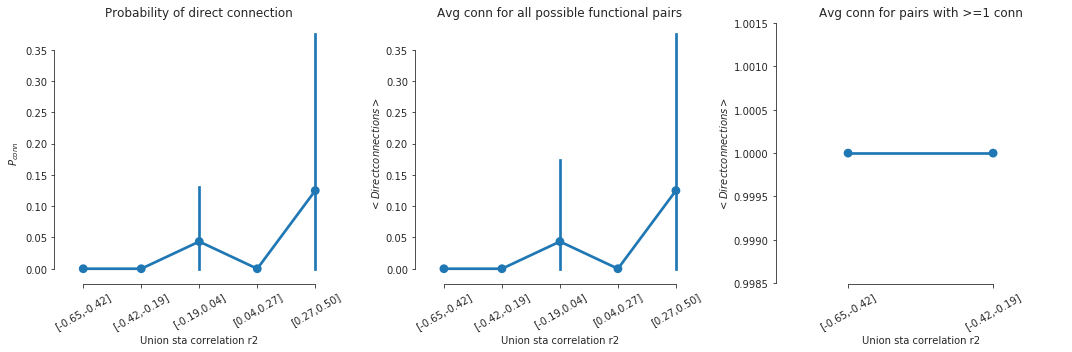

In [72]:
# for difference in preferred orientation 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_union_corr_r2', 'n_syn_binary', data = spatconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_union_corr_r2', 'n_syn_total', data = spatconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_union_corr_r2', 'n_syn_total', data = spatconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[0].set_xlabel('Union sta correlation r2')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[1].set_xlabel('Union sta correlation r2')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[2].set_xlabel('Union sta correlation r2')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()



# Shared Input

## Orientation / Direction

In [ ]:
sig_units = radtune.BestVonFit.Unit & 'von_p_value <= 0.002' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                 sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
radconn_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * fc.SharedInput.proj(*attrs, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())

In [ ]:
radconn_df

In [ ]:
# bin diff_pref_ori, diff_pref_dir, diff_sharp
radconn_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radconn_df['diff_pref_ori']), ori_edges)) - 1]
radconn_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radconn_df['diff_pref_dir']), dir_edges)) - 1]
radconn_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radconn_df['diff_sharp']), sharp_edges))]

In [ ]:
# for difference in preferred orientation 
radconn_df['percent_shared'] = radconn_df['n_seg_shared'] / radconn_df['n_seg_union']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_ori', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_pref_ori', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_pref_ori', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



In [ ]:
# for difference in preferred direction of motion 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_dir', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_pref_dir', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_pref_dir', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



In [ ]:
# for difference in tuning sharpness

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_sharp', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_sharp', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_sharp', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[0].set_xlabel(r'$\Delta$ tuning sharpness')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[1].set_xlabel(r'$\Delta$ tuning sharpness')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[2].set_xlabel(r'$\Delta$ tuning sharpness')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



## Receptive field

In [ ]:
# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                  sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
spatconn_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * fc.SharedInput.proj(*attrs, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


In [ ]:
# set up bins for `union_corr_r2`
union_edges = np.linspace(min(spatconn_df['union_corr_r2']), max(spatconn_df['union_corr_r2']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

In [ ]:
# bin `union_corr_r2`
spatconn_df['bin_union_corr_r2'] = union_centers[(np.digitize(spatconn_df['union_corr_r2'], union_edges))]


In [ ]:
# for union_corr_r2 
spatconn_df['percent_shared'] = spatconn_df['n_seg_shared'] / spatconn_df['n_seg_union']
 
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_union_corr_r2', 'n_seg_shared', data = spatconn_df, ax=ax[0]) 
sns.pointplot('bin_union_corr_r2', 'n_seg_union', data = spatconn_df, ax=ax[1])  
sns.pointplot('bin_union_corr_r2', 'percent_shared', data = spatconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[0].set_xlabel('Union sta correlation r2')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[1].set_xlabel('Union sta correlation r2')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[2].set_xlabel('Union sta correlation r2')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()

